In [1]:
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
iris = load_iris()
X, y = iris.data, iris.target
# clf = tree.DecisionTreeClassifier()
# clf = clf.fit(X, y)
iris.keys()

# from sklearn.datasets import load_wine
# wine = load_wine()
# X, y = wine.data, wine.target
# wine.keys()


dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [2]:
X.shape, y.shape

((150, 4), (150,))

In [3]:
import numpy as np
from collections import Counter
import random
from tree.decision_tree import DecisionTree

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=10)

In [5]:
clf = DecisionTree(max_depth=5, criterion='entropy')
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)
accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)

(1.0, 0.9736842105263158)

In [6]:
clf = DecisionTree(max_depth=5, criterion='gini')
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)
accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)

(1.0, 0.9736842105263158)

In [7]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)
accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)

(1.0, 0.9736842105263158)

In [8]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)
accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)

(1.0, 0.9473684210526315)

1.0 0.9736842105263158


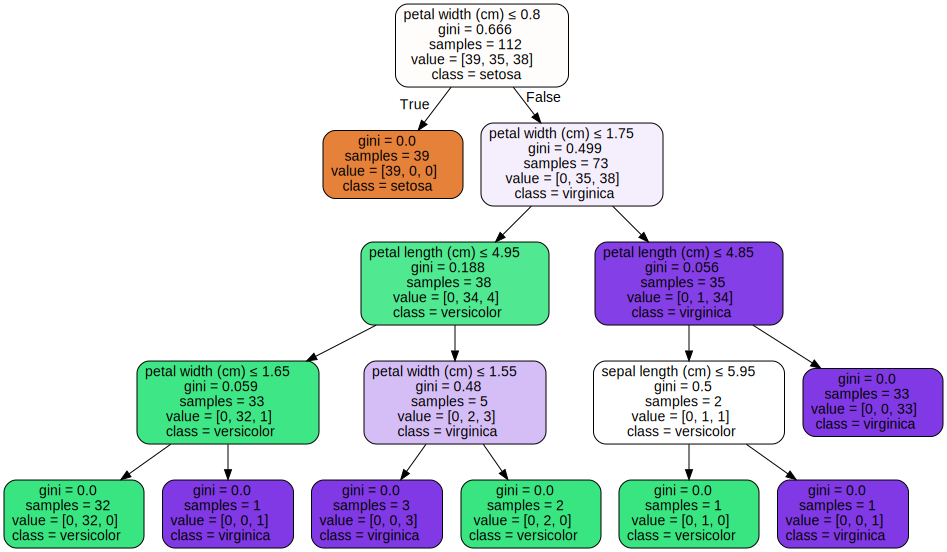

In [9]:
import graphviz

clf = tree.DecisionTreeClassifier(max_depth=5, criterion='gini')
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)
print(accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))

dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=iris.feature_names,  
                     class_names=iris.target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
graph 

In [10]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

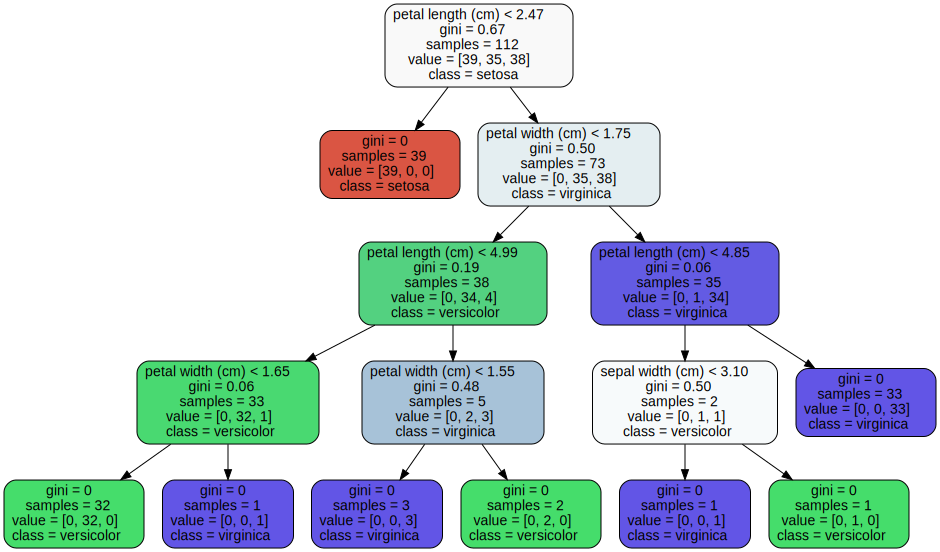

In [11]:
clf = DecisionTree(max_depth=10, criterion='gini', features_to_skip=[0])
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)
accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)
dot_data = clf.export_graphviz(feature_names=iris.feature_names, class_names=iris.target_names)
graph = graphviz.Source(dot_data)
graph 

In [25]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
data = load_diabetes()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=10)
data.keys()

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])

In [28]:
clf = tree.DecisionTreeRegressor(max_depth=10)
# clf = RandomForestRegressor()
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)
# accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)
print(r2_score(y_test, y_test_pred), mean_squared_error(y_test, y_test_pred), r2_score(y_test, np.ones(y_test.shape)*np.mean(y_test)))
# dot_data = clf.export_graphviz(feature_names=data.feature_names, regression=True)
# graph = graphviz.Source(dot_data)
# graph 

0.05359084256742741 5943.4404447790985 0.0


/home/tvpc00032/miniconda3/envs/ml_scratch/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tvpc00032/miniconda3/envs/ml_scratch/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/tvpc00032/Code/projects/ml-from-scratch/packages/tree/tree/decision_tree.py:49: RuntimeWarning: invalid value encountered in scalar divide
  variance = np.sum([(yi - mean)**2 for yi in y])/total


-0.13215792403115922 7109.940920075404 0.0


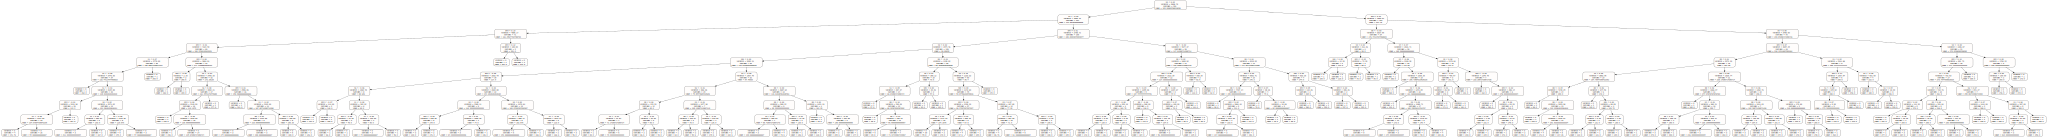

In [29]:
clf = DecisionTree(max_depth=10, criterion='variance', features_to_skip=[0])
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)
# accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)
print(r2_score(y_test, y_test_pred), mean_squared_error(y_test, y_test_pred), r2_score(y_test, np.ones(y_test.shape)*np.mean(y_test)))
dot_data = clf.export_graphviz(feature_names=data.feature_names, regression=True)
graph = graphviz.Source(dot_data)
graph 

In [19]:
y_test

array([200., 202.,  67.,  80., 151., 145.,  65., 308.,  42.,  92., 150.,
       202., 184., 101.,  47., 237.,  88., 152., 109.,  89., 163., 274.,
       138., 275.,  63., 154., 131.,  91., 128., 129., 243., 200.,  72.,
       185., 296., 144.,  75., 175., 281., 292., 292., 214., 275.,  92.,
        65.,  31.,  53.,  51., 258.,  40.,  69.,  86., 142., 128., 243.,
        55., 144., 230., 265.,  63., 217., 102.,  66., 101., 137., 261.,
       147.,  64., 252.,  59., 220., 126.,  43.,  48., 217., 164., 143.,
       206.,  72., 110., 244.,  51.,  52., 302., 276., 150., 124., 114.,
       179.,  91., 257.,  84., 131., 150., 293., 127.,  39.,  83., 191.,
        65.,  65., 265., 242., 219.,  69., 178., 170., 279.,  83.,  45.,
       178.])

In [20]:
y_test_pred

array([ 90.        , 217.25      , 183.22222222,  61.16666667,
       129.64285714, 129.64285714,  85.75      , 332.        ,
       102.        ,  93.        , 133.        , 159.25      ,
        96.33333333,  70.33333333,  61.16666667,  85.        ,
        99.8       ,  37.        ,  85.        ,  99.8       ,
       171.        , 202.        , 103.66666667, 125.        ,
        55.        ,  95.        , 116.        , 167.        ,
       217.25      , 252.        , 180.        , 141.        ,
        99.8       , 149.5       , 215.33333333, 116.        ,
        99.8       ,  52.        , 270.        ,  94.66666667,
       131.        ,  99.8       ,  68.        ,  73.5       ,
       158.        , 175.        ,  74.66666667,  99.8       ,
       332.        , 170.        ,  85.75      ,  74.66666667,
       252.        , 332.        , 173.        ,  94.66666667,
       191.66666667,  95.        , 171.        ,  85.75      ,
       183.22222222,  61.16666667,  85.75      ,  55.  